In [22]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
data0 = pd.read_csv('full_hand_data.csv')#, names=['name','state'])

In [25]:
data0.head()

,name,state
0,data/fdata1/hand_pic/a_232bf02f_0_lc.jpg,0
1,data/fdata1/hand_pic/a_232bf02f_1_lo.jpg,1
2,data/fdata1/hand_pic/a_232bf02f_2_lq.jpg,2
3,data/fdata1/hand_pic/a_232bf02f_3_lw.jpg,3
4,data/fdata1/hand_pic/a_232bf02f_4_le.jpg,4


In [26]:
num_class = len(data0['state'].unique())

In [27]:
import json
with open('num2ges.json') as fin:
    num_to_ges = json.load(fin, encoding='latin')
num_to_ges

{u'0': u' lc',
 u'1': u' lo',
 u'10': u' mc',
 u'11': u' mo',
 u'12': u' mq',
 u'13': u' mw',
 u'14': u' me',
 u'15': u' m1',
 u'16': u' m2',
 u'17': u' m3',
 u'18': u' m4',
 u'19': u' m5',
 u'2': u' lq',
 u'20': u' rc',
 u'21': u' ro',
 u'22': u' rq',
 u'23': u' rw',
 u'24': u' re',
 u'25': u' r1',
 u'26': u' r2',
 u'27': u' r3',
 u'28': u' r4',
 u'29': u' r5',
 u'3': u' lw',
 u'4': u' le',
 u'5': u' l1',
 u'6': u' l2',
 u'7': u' l3',
 u'8': u' l4',
 u'9': u' l5'}

In [28]:
# data0 = data0.replace({'state':ges_to_num})

In [29]:
data0.shape

(2160, 2)

In [30]:
labels = np.empty((data0.shape[0]))

res_width, res_height = 200, 200
imgs = np.empty(shape=(data0.shape[0],3, res_width,res_height))
imgs.shape, labels.shape

((2160, 3, 200, 200), (2160,))

In [31]:

for i, (im_path, state) in enumerate(data0.values):
#     im_path = prefix + im_name
#     print im_path
    img = cv2.imread(im_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    res = cv2.resize(gray,(200, 200), interpolation=cv2.INTER_CUBIC)

    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 1, 2)
    res = res[np.newaxis, :]

    imgs[i] = res
    labels[i] = state

In [32]:
# plt.imshow(gray)

In [33]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

In [34]:
# train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((1944, 3, 200, 200), (1944,), (216, 3, 200, 200), (216,))

In [35]:
test_label

array([  0.,   9.,  27.,   3.,  14.,   4.,   7.,  26.,  24.,  16.,   5.,
         5.,   8.,  11.,  21.,   4.,  13.,  11.,   4.,  29.,  27.,  11.,
        15.,  26.,   3.,   5.,  13.,  24.,  23.,  15.,  15.,  11.,  21.,
         7.,  29.,  26.,  19.,  16.,  24.,  20.,  22.,   5.,  13.,  26.,
        17.,   1.,   1.,  27.,  25.,   1.,   6.,  26.,   7.,  25.,  17.,
        10.,   3.,  27.,   8.,  13.,  10.,  25.,   3.,  21.,  28.,  15.,
        15.,  27.,   5.,  13.,  24.,  16.,  10.,   6.,  15.,  11.,  29.,
        20.,   4.,  15.,   7.,  11.,   6.,  19.,  17.,  29.,  12.,   5.,
         1.,  24.,  13.,   5.,  23.,  19.,  29.,  28.,   6.,  21.,  15.,
        13.,   8.,  16.,   8.,  17.,  18.,  15.,   7.,  11.,  21.,  15.,
         9.,  11.,  28.,   4.,  11.,  22.,   4.,  10.,  23.,   6.,  11.,
         7.,  29.,  25.,   7.,   2.,  22.,   6.,  23.,  15.,   2.,   8.,
        22.,  21.,  13.,  25.,   0.,  26.,  11.,  24.,   4.,   3.,  12.,
         2.,  14.,  22.,  29.,  13.,  10.,   1.,   

In [36]:
batch_size = 128
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

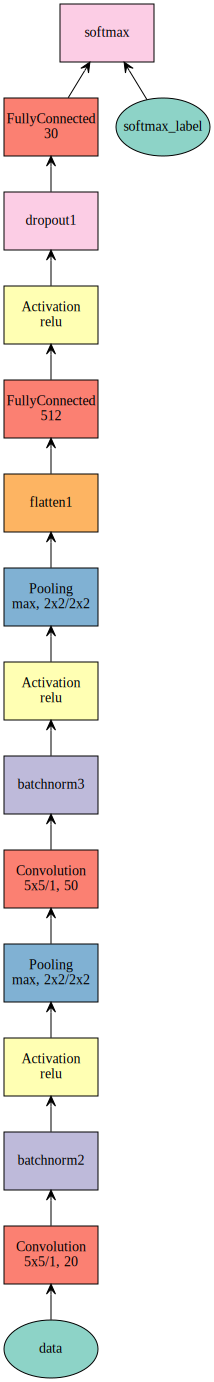

In [37]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='relu')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='relu')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type='relu')

drop = mx.symbol.Dropout(tanh3, p=0.5)
fc2 = mx.sym.FullyConnected(data=drop, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(convnet)

In [42]:
model = mx.mod.Module(symbol=convnet, context=mx.gpu())

In [43]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.01))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.001, 'wd': 0.001})

metric = mx.metric.Accuracy()

In [44]:
chk_prefix='models/chkpt'
for epoch in range(400):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
    
    if epoch % 30 == 0:
#         model_path = '{}_{}'.format(chk_prefix, epoch)
        model.save_checkpoint(chk_prefix, epoch)
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

INFO:root:Saved checkpoint to "models/chkpt-0000.params"


Epoch 0, Training ('accuracy', 0.06298828125), Time 7.57
Epoch 1, Training ('accuracy', 0.1279296875), Time 5.59
Epoch 2, Training ('accuracy', 0.19873046875), Time 5.82
Epoch 3, Training ('accuracy', 0.279296875), Time 5.82
Epoch 4, Training ('accuracy', 0.34423828125), Time 5.82
Epoch 5, Training ('accuracy', 0.39599609375), Time 5.83
Epoch 6, Training ('accuracy', 0.455078125), Time 5.82
Epoch 7, Training ('accuracy', 0.49267578125), Time 5.83
Epoch 8, Training ('accuracy', 0.5458984375), Time 5.83
Epoch 9, Training ('accuracy', 0.58642578125), Time 5.82
Epoch 10, Training ('accuracy', 0.6123046875), Time 5.83
Epoch 11, Training ('accuracy', 0.65283203125), Time 5.82
Epoch 12, Training ('accuracy', 0.6845703125), Time 5.83
Epoch 13, Training ('accuracy', 0.6826171875), Time 5.82
Epoch 14, Training ('accuracy', 0.7275390625), Time 5.82
Epoch 15, Training ('accuracy', 0.73974609375), Time 5.82
Epoch 16, Training ('accuracy', 0.759765625), Time 5.82
Epoch 17, Training ('accuracy', 0.77

INFO:root:Saved checkpoint to "models/chkpt-0030.params"


Epoch 30, Training ('accuracy', 0.91064453125), Time 7.71
Epoch 31, Training ('accuracy', 0.89794921875), Time 5.59
Epoch 32, Training ('accuracy', 0.9111328125), Time 5.83
Epoch 33, Training ('accuracy', 0.90966796875), Time 5.83
Epoch 34, Training ('accuracy', 0.92431640625), Time 5.83
Epoch 35, Training ('accuracy', 0.9208984375), Time 5.83
Epoch 36, Training ('accuracy', 0.92724609375), Time 5.83
Epoch 37, Training ('accuracy', 0.931640625), Time 5.83
Epoch 38, Training ('accuracy', 0.92724609375), Time 5.82
Epoch 39, Training ('accuracy', 0.9375), Time 5.83
Epoch 40, Training ('accuracy', 0.93505859375), Time 5.82
Epoch 41, Training ('accuracy', 0.9384765625), Time 5.83
Epoch 42, Training ('accuracy', 0.9443359375), Time 5.83
Epoch 43, Training ('accuracy', 0.94140625), Time 5.83
Epoch 44, Training ('accuracy', 0.95166015625), Time 5.83
Epoch 45, Training ('accuracy', 0.9443359375), Time 5.83
Epoch 46, Training ('accuracy', 0.94921875), Time 5.83
Epoch 47, Training ('accuracy', 0.

INFO:root:Saved checkpoint to "models/chkpt-0060.params"


Epoch 60, Training ('accuracy', 0.966796875), Time 6.34
Epoch 61, Training ('accuracy', 0.96630859375), Time 5.59
Epoch 62, Training ('accuracy', 0.97119140625), Time 5.83
Epoch 63, Training ('accuracy', 0.96435546875), Time 5.83
Epoch 64, Training ('accuracy', 0.96484375), Time 5.83
Epoch 65, Training ('accuracy', 0.96923828125), Time 5.83
Epoch 66, Training ('accuracy', 0.9697265625), Time 5.83
Epoch 67, Training ('accuracy', 0.974609375), Time 5.83
Epoch 68, Training ('accuracy', 0.97216796875), Time 5.82
Epoch 69, Training ('accuracy', 0.9755859375), Time 5.83
Epoch 70, Training ('accuracy', 0.97509765625), Time 5.83
Epoch 71, Training ('accuracy', 0.97216796875), Time 5.83
Epoch 72, Training ('accuracy', 0.97216796875), Time 5.82
Epoch 73, Training ('accuracy', 0.970703125), Time 5.83
Epoch 74, Training ('accuracy', 0.97119140625), Time 5.82
Epoch 75, Training ('accuracy', 0.9755859375), Time 5.83
Epoch 76, Training ('accuracy', 0.9736328125), Time 5.82
Epoch 77, Training ('accura

INFO:root:Saved checkpoint to "models/chkpt-0090.params"


Epoch 90, Training ('accuracy', 0.978515625), Time 6.34
Epoch 91, Training ('accuracy', 0.97607421875), Time 5.59
Epoch 92, Training ('accuracy', 0.97998046875), Time 5.83
Epoch 93, Training ('accuracy', 0.9755859375), Time 5.83
Epoch 94, Training ('accuracy', 0.97998046875), Time 5.83
Epoch 95, Training ('accuracy', 0.98388671875), Time 5.83
Epoch 96, Training ('accuracy', 0.98095703125), Time 5.82
Epoch 97, Training ('accuracy', 0.98193359375), Time 5.83
Epoch 98, Training ('accuracy', 0.9853515625), Time 5.83
Epoch 99, Training ('accuracy', 0.98046875), Time 5.82
Epoch 100, Training ('accuracy', 0.9833984375), Time 5.83
Epoch 101, Training ('accuracy', 0.982421875), Time 5.82
Epoch 102, Training ('accuracy', 0.98193359375), Time 5.83
Epoch 103, Training ('accuracy', 0.98046875), Time 5.83
Epoch 104, Training ('accuracy', 0.98291015625), Time 5.83
Epoch 105, Training ('accuracy', 0.98388671875), Time 5.83
Epoch 106, Training ('accuracy', 0.98193359375), Time 5.83
Epoch 107, Training 

INFO:root:Saved checkpoint to "models/chkpt-0120.params"


Epoch 120, Training ('accuracy', 0.98583984375), Time 6.34
Epoch 121, Training ('accuracy', 0.9833984375), Time 5.59
Epoch 122, Training ('accuracy', 0.9912109375), Time 5.83
Epoch 123, Training ('accuracy', 0.9892578125), Time 5.83
Epoch 124, Training ('accuracy', 0.986328125), Time 5.83
Epoch 125, Training ('accuracy', 0.98876953125), Time 5.83
Epoch 126, Training ('accuracy', 0.98583984375), Time 5.83
Epoch 127, Training ('accuracy', 0.98779296875), Time 5.82
Epoch 128, Training ('accuracy', 0.984375), Time 5.82
Epoch 129, Training ('accuracy', 0.98779296875), Time 5.83
Epoch 130, Training ('accuracy', 0.98681640625), Time 5.82
Epoch 131, Training ('accuracy', 0.98583984375), Time 5.83
Epoch 132, Training ('accuracy', 0.98974609375), Time 5.83
Epoch 133, Training ('accuracy', 0.986328125), Time 5.82
Epoch 134, Training ('accuracy', 0.98876953125), Time 5.82
Epoch 135, Training ('accuracy', 0.990234375), Time 5.83
Epoch 136, Training ('accuracy', 0.98876953125), Time 5.83
Epoch 137, 

INFO:root:Saved checkpoint to "models/chkpt-0150.params"


Epoch 150, Training ('accuracy', 0.9892578125), Time 6.34
Epoch 151, Training ('accuracy', 0.98828125), Time 5.59
Epoch 152, Training ('accuracy', 0.9892578125), Time 5.83
Epoch 153, Training ('accuracy', 0.9873046875), Time 5.83
Epoch 154, Training ('accuracy', 0.99169921875), Time 5.83
Epoch 155, Training ('accuracy', 0.99267578125), Time 5.83
Epoch 156, Training ('accuracy', 0.99072265625), Time 5.83
Epoch 157, Training ('accuracy', 0.9912109375), Time 5.82
Epoch 158, Training ('accuracy', 0.98876953125), Time 5.83
Epoch 159, Training ('accuracy', 0.99169921875), Time 5.82
Epoch 160, Training ('accuracy', 0.99169921875), Time 5.83
Epoch 161, Training ('accuracy', 0.9921875), Time 5.83
Epoch 162, Training ('accuracy', 0.9921875), Time 5.83
Epoch 163, Training ('accuracy', 0.9921875), Time 5.83
Epoch 164, Training ('accuracy', 0.99169921875), Time 5.83
Epoch 165, Training ('accuracy', 0.98876953125), Time 5.83
Epoch 166, Training ('accuracy', 0.99072265625), Time 5.83
Epoch 167, Train

INFO:root:Saved checkpoint to "models/chkpt-0180.params"


Epoch 180, Training ('accuracy', 0.99462890625), Time 6.34
Epoch 181, Training ('accuracy', 0.990234375), Time 5.60
Epoch 182, Training ('accuracy', 0.9921875), Time 5.83
Epoch 183, Training ('accuracy', 0.9921875), Time 5.83
Epoch 184, Training ('accuracy', 0.9921875), Time 5.83
Epoch 185, Training ('accuracy', 0.99169921875), Time 5.83
Epoch 186, Training ('accuracy', 0.9931640625), Time 5.83
Epoch 187, Training ('accuracy', 0.99267578125), Time 5.83
Epoch 188, Training ('accuracy', 0.9921875), Time 5.83
Epoch 189, Training ('accuracy', 0.99462890625), Time 5.83
Epoch 190, Training ('accuracy', 0.9951171875), Time 5.83
Epoch 191, Training ('accuracy', 0.9912109375), Time 5.83
Epoch 192, Training ('accuracy', 0.99072265625), Time 5.83
Epoch 193, Training ('accuracy', 0.99365234375), Time 5.83
Epoch 194, Training ('accuracy', 0.99462890625), Time 5.83
Epoch 195, Training ('accuracy', 0.99267578125), Time 5.83
Epoch 196, Training ('accuracy', 0.9931640625), Time 5.82
Epoch 197, Training

INFO:root:Saved checkpoint to "models/chkpt-0210.params"


Epoch 210, Training ('accuracy', 0.99365234375), Time 6.34


KeyboardInterrupt: 

In [45]:
model.score(eval_iter, metric)

[('accuracy', 0.984375)]

In [ ]:
# ls data1

In [ ]:
# # I took a picture of my hand 
# pred_im = cv2.imread('data1/test-crop.png', 0)
# plt.imshow(pred_im)

In [ ]:
# pred_im.shape

In [ ]:
# pred_res = cv2.resize(pred_im,(200, 200), interpolation = cv2.INTER_CUBIC)
# plt.imshow(pred_res)

In [ ]:
# test_ = np.empty((1,1,200,200))
# test_[0][0] = pred_res
# lb = np.array([0])

In [ ]:
# test_.shape#, lb.shape

In [ ]:
# eval_iter = mx.io.NDArrayIter(test_, lb, batch_size=1)

In [ ]:
# d = Batch([mx.nd.array(pred_res)])
# # d, pred_res.shape
# model.forward(data_batch=d)

In [ ]:
# def get_image(url, show=False):
#     # download and show the image
# #     fname = mx.test_utils.download(url)
# #     img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
#     img = cv2.imread(url, 0)
#     if img is None:
#          return None
#     if show:
#          plt.imshow(img)
#          plt.axis('off')

#     img = cv2.resize(img, (200, 200), interpolation = cv2.INTER_CUBIC)
# #     img = np.swapaxes(img, 0, 2)
# #     img = np.swapaxes(img, 1, 2)
#     img = img[np.newaxis, np.newaxis, :]
#     return img

In [ ]:
# from collections import namedtuple
# Batch = namedtuple('Batch', ['data'])
# def predict(url):
#     img = get_image(url, show=True)
#     print img.shape
#     print Batch([mx.nd.array(img)])
#     # compute the predict probabilities
# #     model.forward(Batch([mx.nd.array(img)]), is_train=False)
# #     prob = mod.get_outputs()[0].asnumpy()
# #     # print the top-5
# #     prob = np.squeeze(prob)
# #     a = np.argsort(prob)[::-1]
# #     for i in a[0:5]:
# #         print('probability=%f, class=%s' %(prob[i], labels[i]))

In [ ]:
# # test picture with label 0
# # pred = model.predict(eval_iter)#.asnumpy()
# predict('data1/test-crop.png')

In [ ]:
# pred.argmax() # correct!

In [48]:
sym, arg_params, aux_params = mx.model.load_checkpoint('models/chkpt', 210)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,200,200))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

In [55]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

mod.forward(Batch([mx.nd.array(res)]))

In [57]:
mod.get_outputs()[0]


[[  1.07715632e-08   8.27669567e-07   8.37977893e-07   3.39835642e-05
    7.99212648e-06   6.54119503e-07   9.99485110e-07   5.14404292e-06
    4.32374654e-05   2.37050335e-09   3.48504291e-05   3.76414590e-07
    1.09531293e-05   6.28522757e-05   7.16310478e-06   1.60254403e-05
    1.17708172e-04   1.41441080e-04   1.19263780e-06   7.00090372e-04
    1.82696458e-05   1.46264331e-02   2.30391279e-08   9.25918903e-06
    2.49642995e-04   3.70244466e-04   5.02268435e-04   9.87173116e-05
    3.34505085e-03   9.79593754e-01]]
<NDArray 1x30 @cpu(0)>

In [ ]:
#    # save a model to mymodel-symbol.json and mymodel-0100.params
#     prefix = 'mymodel'
#     iteration = 100
#     model.save(prefix, iteration)

#     # load model back
#     model_loaded = mx.model.FeedForward.load(prefix, iteration)